# Advanced Lane finding - Project 4 of CarND Term1
This notebook implements the software pipeline to detect the road lanes for a self driving car using the advanced lane detection tools described in the module. The notebook depends on calibration and test data from the project repositery on github
https://github.com/udacity/CarND-Advanced-Lane-Lines

In [4]:
# Import all necessary packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import math

## Camera calibration
Calibrate the camera using the calibration images provided in the project repositery.

In [95]:
class CameraCalibrator:
    def __init__(self, path, chess_w, chess_h):
        """Initializes the Camera calibrator class.
        
        Calibrates the camera using the cv2 functions.

        Args:
            path: Path to the calibration chess board images.
            chess_w: Number of columns of chess board.
            chess_h: Number of rows of chess board.
        Returns:
            None.               
        """
        # Read calibration images
        imgfiles = glob.glob(path)

        # Initialize arrays to store object points and image points
        objpoints = [] # 3D points in real world
        imgpoints = [] # 2D points in image plane

        # Prepare object points, will be same for all images
        objp = np.zeros((chess_w*chess_h, 3), np.float32)
        objp[:, :2] = np.mgrid[0:chess_w, 0:chess_h].T.reshape(-1, 2)

        print('Calibrating the camera using images at '+path)
        # Loop through calibration images
        for imgfile in imgfiles:    
            img = mpimg.imread(imgfile)
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, (chess_w, chess_h), None)
            if ret == True:
                # Append detected corners to imgpoints
                imgpoints.append(corners)        
                objpoints.append(objp)

        # Calibrate the camera using imgpoints and objpoints        
        ret, self.mtx, self.dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        print('Calibration completed with ret: '+str(np.around(ret, 2)))
       
    def Undistort(self, image, show=False):
        """Undistorts an input image.
        
        Undistorts an input image using the camera matrix and distortion co-efficients calibrated during __init__

        Args:
            image: Input image.
            show: Optional argument to show the input and output images using imshow.
        Returns:
            Undistorted image.               
        """
        undist_image = cv2.undistort(image, self.mtx, self.dist, None, self.mtx)
        
        if (show == True):
            self.__ShowImages(image, undist_image, 'Image', 'Undistorted image')
            
        return image
    
    def __ShowImages(self, im1, im2, title1, title2):
        """Show images.
        
        Show images using imshow

        Args:
            image: Input image.
            im1: Image 1
            im2: Image 2
            title1: Title for im1
            title2: Title for im2
        Returns:
            None
        """        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        f.tight_layout()
        ax1.set_title(title1)
        ax1.imshow(im1)
        ax2.set_title(title2)
        ax2.imshow(im2)

# Instantiate a camera calibrator class with path to calibration images and chess board dimensions        
calibrator = CameraCalibrator('./camera_cal/calibration*.jpg', 9, 6)

Calibrating the camera using images at ./camera_cal/calibration*.jpg
Calibration completed with ret: 1.19


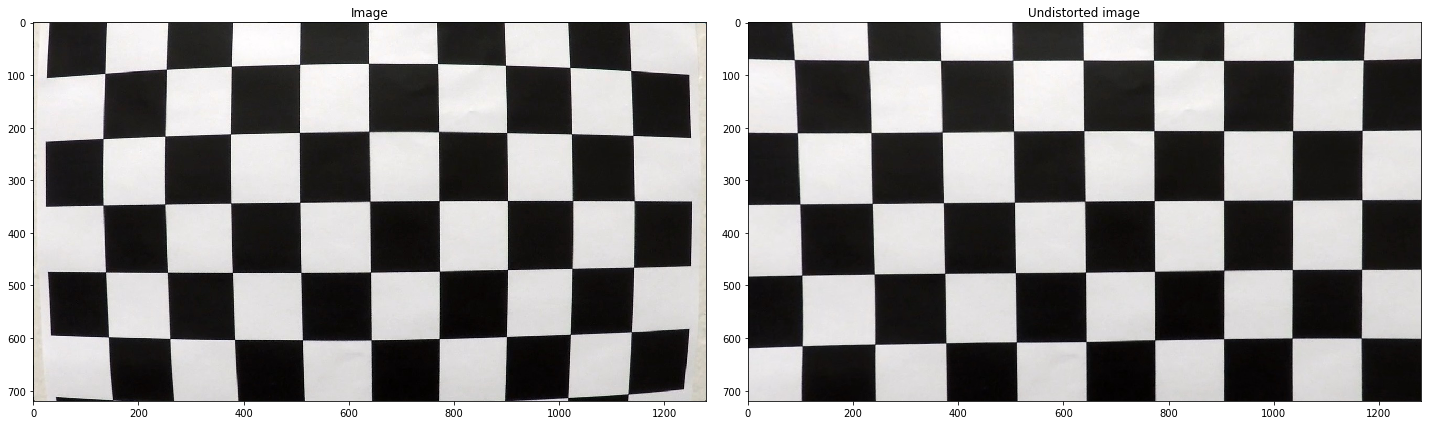

In [96]:
# Test camera calibrator
test_fname = 'camera_cal/calibration1.jpg'
dist_img = mpimg.imread(test_fname)
undist_img = calibrator.Undistort(dist_img, show=True)

## Gradient and Color threshold

In [97]:
class Thresholder:
    def apply_gradients(self, image, ksize=3, show=False):
        """Apply thresholds to gradient of the input image.
        
        Applies thresholds to graident of the input image.
            The function applies Gaussian blur as a pre-processing step to remove the noise.
            Applies the thresholds to,
                Sobel graident Along 'x' and 'y'
                Magnitude of the Sobel gradient
                Direction of the Sobe gradient
            
        Args:
            image: Input RGB image.
        Optiona Args:    
            ksize: Kernel size of sobel operator.
            show: show the input and output image.
        Returns:
            Output binary image.
        """
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Apply gaussian blur to remove noise
        blurred_gray = cv2.GaussianBlur(gray, (5,5), 0)        

        # Take the gradient in x and y separately
        sobelx = cv2.Sobel(blurred_gray, cv2.CV_64F, 1, 0, ksize=ksize)
        sobely = cv2.Sobel(blurred_gray, cv2.CV_64F, 0, 1, ksize=ksize)

        # Take the absolute value of the x and y gradients
        abs_sobelx = np.absolute(sobelx)
        abs_sobely = np.absolute(sobely)

        # Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scaled_gradx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        scaled_grady = np.uint8(255*abs_sobely/np.max(abs_sobely))

        # Calculate direction of the gradient using np.arctan2(abs_sobely, abs_sobelx)
        dir_grad = np.arctan2(abs_sobely, abs_sobelx)
        
        # Calculate the magnitude of the gradient
        sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))
        # Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scaled_grad_mag = np.uint8(255*sobelxy/np.max(sobelxy))

        # Filter scaled_gradx and scaled_grady using thresholds
        scaled_gradx_filt = cv2.inRange(scaled_gradx, 20, 100)
        scaled_grady_filt = cv2.inRange(scaled_grady, 20, 100)

        # Filter scaled_grad_mag and dir_grad using thresholds
        scaled_grad_mag_filt = cv2.inRange(scaled_grad_mag, 30, 100)
        dir_grad_filt = cv2.inRange(dir_grad, math.radians(40), math.radians(70))
        
        # Create binary output image
        grad_bin = np.zeros_like(scaled_gradx_filt)
        grad_bin[((scaled_gradx_filt != 0)    & (scaled_grady_filt != 0)) | 
                 ((scaled_grad_mag_filt != 0) & (dir_grad_filt != 0))] = 1
        
        if (show == True):
            self.__ShowImages(image, scaled_gradx_filt, 'Image', 'Gradient X')
            self.__ShowImages(image, scaled_grady_filt, 'Image', 'Gradient Y')
            self.__ShowImages(image, scaled_grad_mag_filt, 'Image', 'Gradient Magnitude')
            self.__ShowImages(image, dir_grad_filt, 'Image', 'Gradient Direction')
            self.__ShowImages(image, grad_bin, 'Image', 'Combined Gradient')

        # Return binary output
        return grad_bin 
    

    def apply_colors(self, image, show=False):
        """Apply thresholds to colors of the input image.
        
        Applies thresholds to colors of the input image 
            such that all colors except white and yellow are suppressed.
            Implementation is based on 
            https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html
          
        Args:
            image: Input RGB image.
        Optiona Args:    
            show: show the input and output image.
        Returns:
            Output binary image.
        """
        # Convert to HLS color space (better for extracting white)
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

        # define range of white color in HLS
        lo_white = np.array([0,  200,0])
        up_white = np.array([255,255,255])
        
        # Threshold the HLS image to get white colored region
        mask_white = cv2.inRange(hls, lo_white, up_white)

        # Convert to HSV color space (better for extracting yellow)
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

        # define range of yellow color in HSV
        lo_yel = np.array([20,100,100])
        up_yel = np.array([40,255,255])
        
        # Threshold the HSV image to get yellow colored region
        mask_yel = cv2.inRange(hsv, lo_yel, up_yel)     

        # Create binary output
        col_bin = np.zeros_like(mask_white)
        col_bin[((mask_yel != 0) | (mask_white != 0))] = 1
        
        if (show == True):
            self.__ShowImages(image, mask_yel, 'Image', 'Yellow')
            self.__ShowImages(image, mask_white, 'Image', 'White')
            self.__ShowImages(image, col_bin, 'Image', 'Yellow+White')

        # Return binary output
        return col_bin
    
    def apply_all(self, image, show=False):
        """Apply thresholds to gradients and colors of the input image.
        
        Applies thresholds to input image properties 
            like gradient and color such that pixels belonging to left and right lanes are highlighted.
          
        Args:
            image: Input RGB image.
        Optiona Args:    
            show: show the input and output image.
        Returns:
            Output binary image with bits set to 1 for pixels belonging to lanes.
        """        
        # Apply gradient thresholds
        grad_bin = self.apply_gradients(image, show=show)
        
        # Apply color thresholds
        col_bin = self.apply_colors(image, show=show)
                        
        # Combine the two binary thresholds
        com_bin = grad_bin | col_bin     

        if (show == True):
            self.__ShowImages(image, com_bin, 'Image', 'Thresholded Image')          
            
        return com_bin

    def __ShowImages(self, im1, im2, title1, title2):
        """Show images.
        
        Show images using imshow

        Args:
            image: Input image.
            im1: Image 1
            im2: Image 2
            title1: Title for im1
            title2: Title for im2
        Returns:
            None
        """        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        f.tight_layout()
        ax1.set_title(title1)
        ax1.imshow(im1)
        ax2.set_title(title2)
        ax2.imshow(im2, cmap='gray')

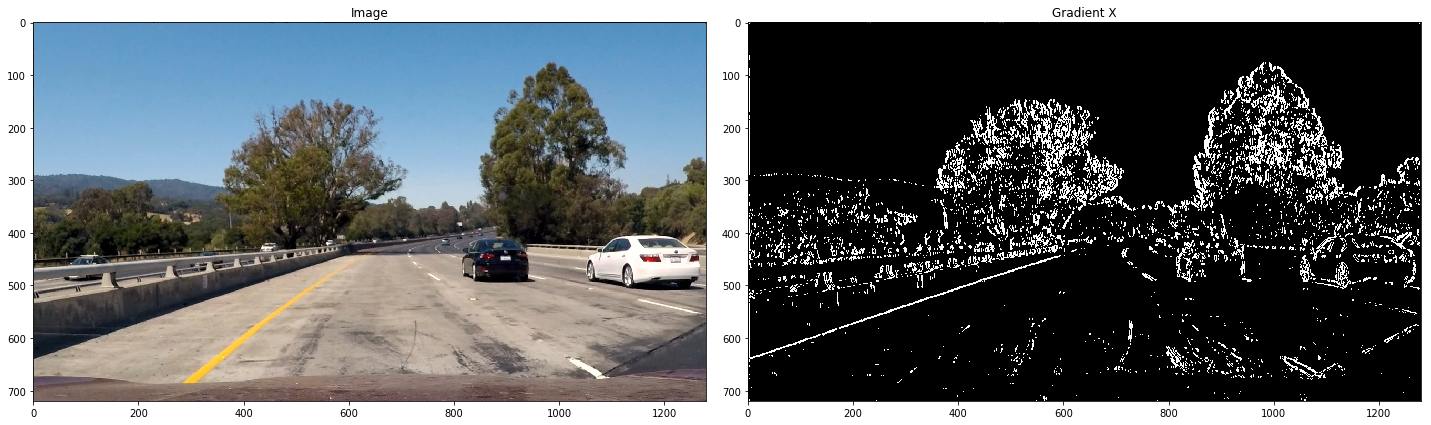

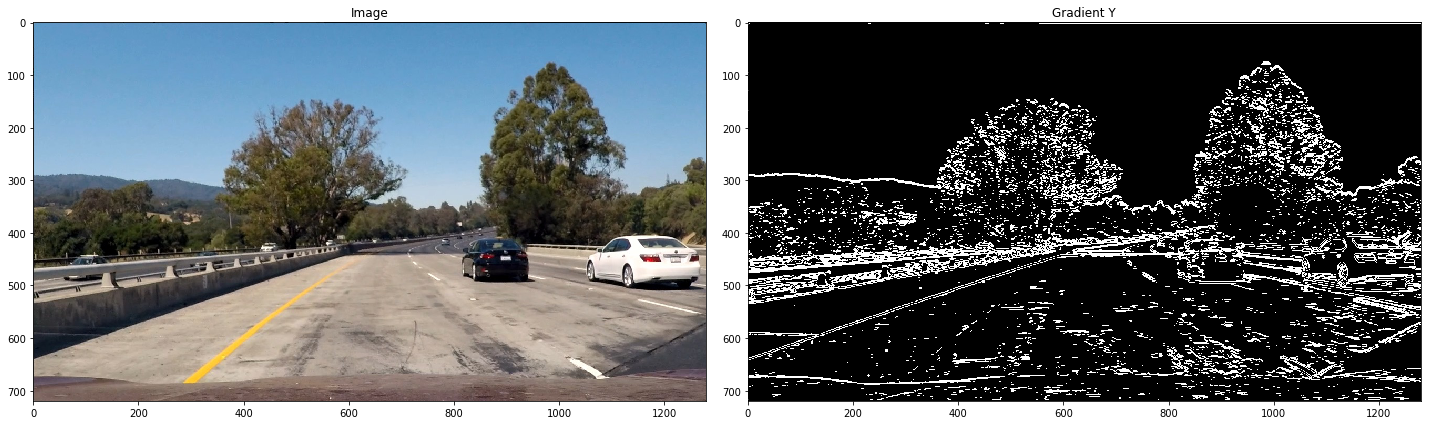

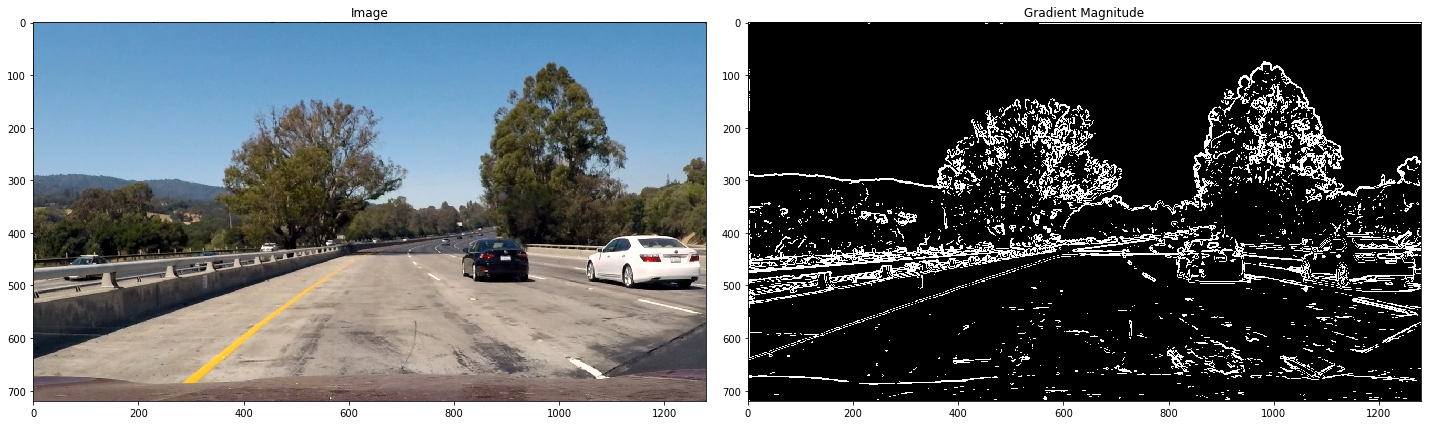

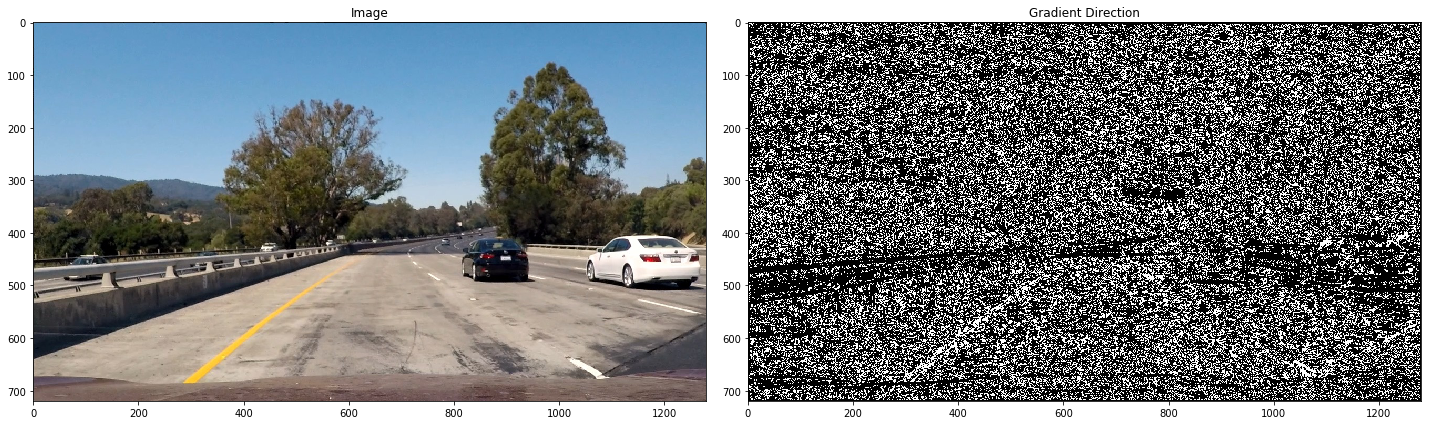

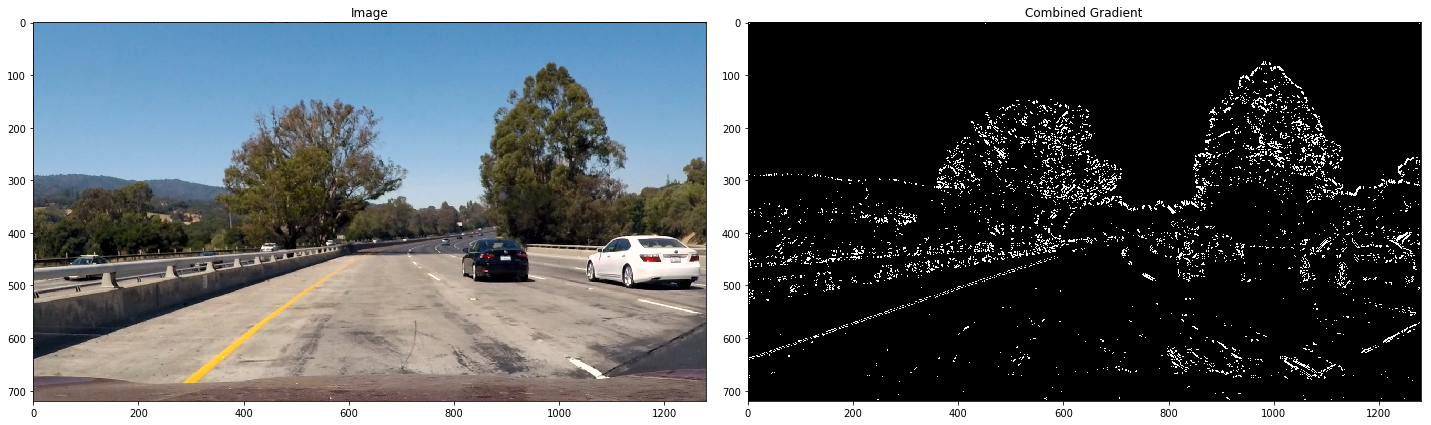

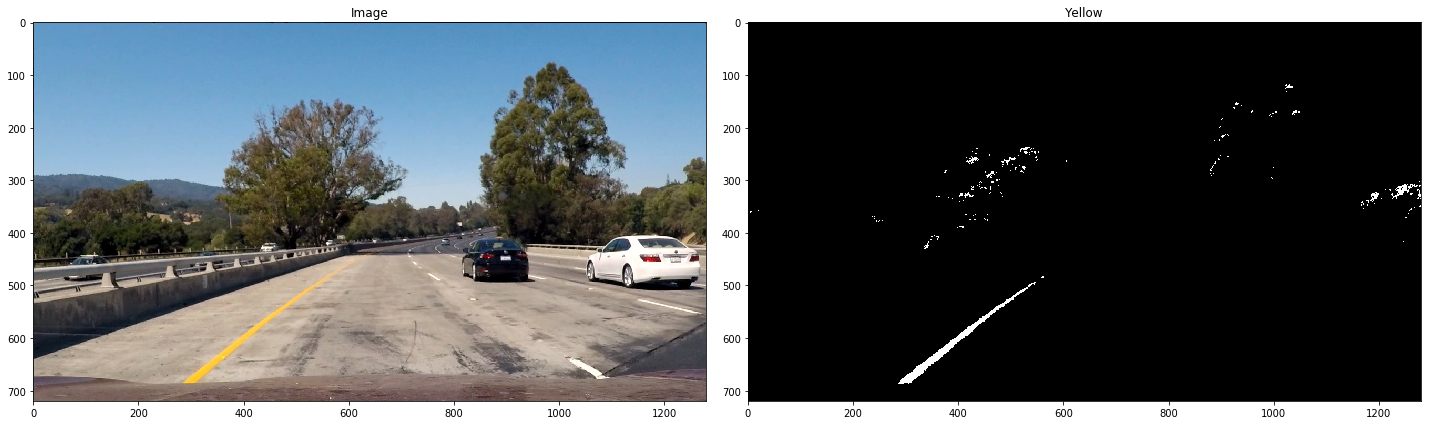

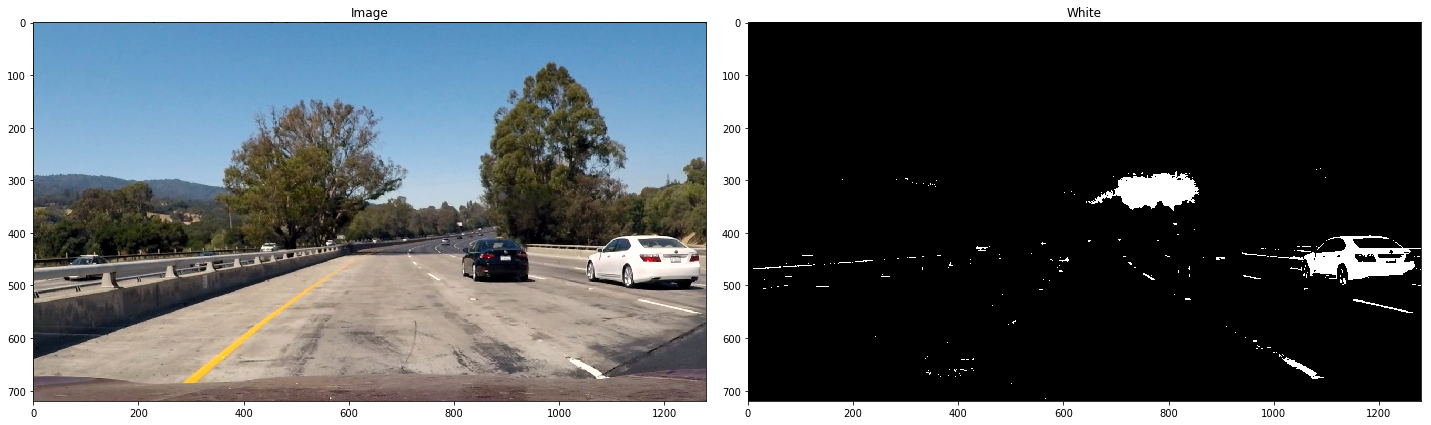

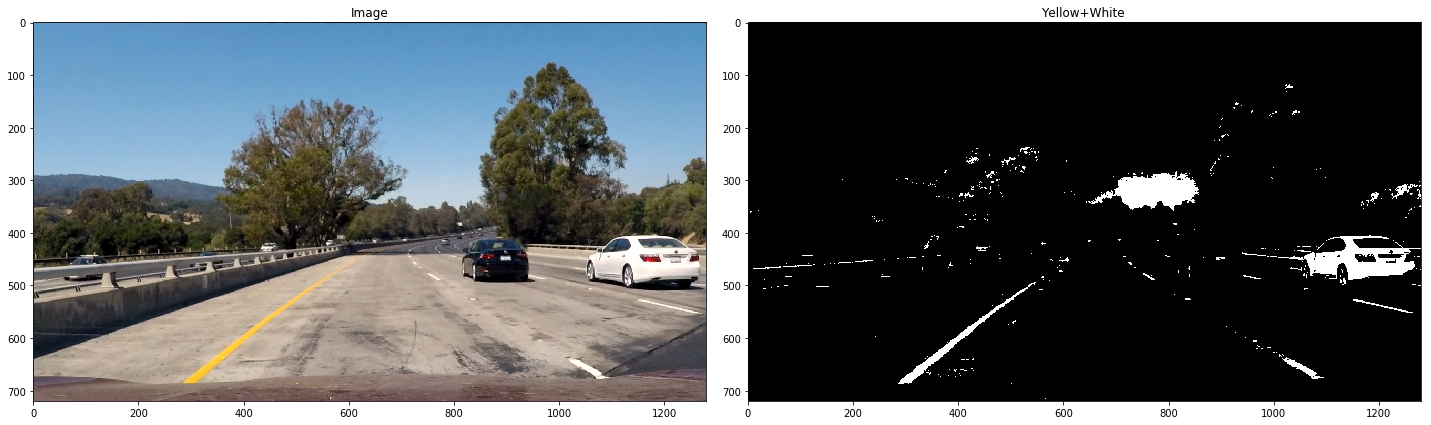

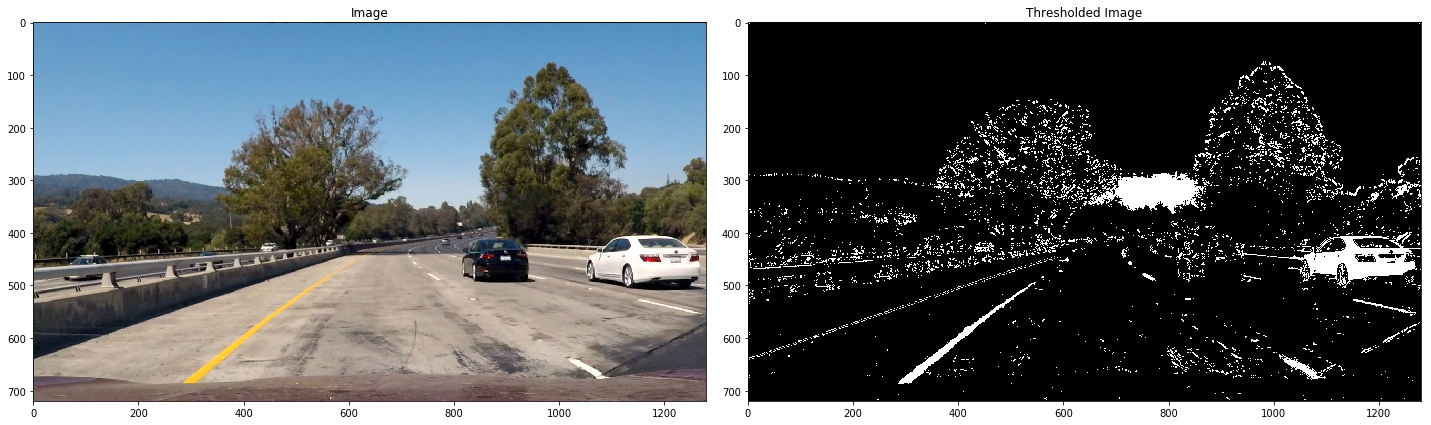

In [98]:
# Test thresholding
thresholder = Thresholder()
image = mpimg.imread('test_images/test1.jpg')
undist_image = calibrator.Undistort(image)
warped_image = thresholder.apply_all(undist_image, show=True)

## Perspective Transformation

In [102]:
class PerspectiveTransformer():
    def __init__(self):
        """Initializes the Perspective Transformer class.
        
        Computes the perspective transform matrix and inverse perspective transform matrix.
            These matrices are used by Warp() and Unwarp() methods.

        Args:
            None
        Returns:
            None.               
        """    
        # Points     [(left_bot ), (left top ), (right bot), (right top)]
        self.s_pts = [(230,  700), (590,  450), (680,  450), (1080, 700)]
        self.d_pts = [(250,  700), (250,    0), (1000,   0), (1000, 700)]
        src = np.float32(self.s_pts)
        dst = np.float32(self.d_pts)
        self.M = cv2.getPerspectiveTransform(src, dst)        
        self.Minv = cv2.getPerspectiveTransform(dst, src)
   
    def Warp(self, image, show=False):
        """Warps an input image using perspective transform matrix.

        Uses the perspective transform matrix (M) computed in __init__()

        Args:
            image: Input image.
        Optional Args:
            show: Show input and output image using imshow
        Returns:
            warped_image.               
        """
        img_size = (image.shape[1], image.shape[0])
        warped_image = cv2.warpPerspective(image, self.M, img_size, flags=cv2.INTER_LINEAR)
        
        if show == True:            
            self.__ShowImages(image.copy(), warped_image.copy(), 'Image', 'Warped Image', True)            
            
        return warped_image
    
    def Unwarp(self, warped_image, show=False):
        """Unwarps an input image using inverse perspective transform matrix.

        Uses the inverse perspective transform matrix (M) computed in __init__()

        Args:
            image: (Warped) Input image.
        Optional Args:
            show: Show input and output image using imshow
        Returns:
            Unwarped_image.               
        """        
        img_size = (warped_image.shape[1], warped_image.shape[0])
        image = cv2.warpPerspective(warped_image, self.Minv, img_size, flags=cv2.INTER_LINEAR)
        
        if show == True:            
            self.__ShowImages(warped_image.copy(), image.copy(), 'Image', 'Unwarped Image', False)
        
        return image
    
    def __ShowImages(self, src, dst, title1, title2, warping):
        """Show images.
        
        Show images using imshow

        Args:
            src: Source image
            dst: Destination image
            title1: Title for src
            title2: Title for dst
            warping: Flag indicating of calling function is Warp or Unwarp
        Returns:
            None
        """        
        color = [1.0]
        thickness = 1

        if (warping == True):            
            s_pts = self.s_pts;
            d_pts = self.d_pts;
        else:
            s_pts = self.d_pts;
            d_pts = self.s_pts;
            
        cv2.line(src, s_pts[0], s_pts[1], color, thickness)        
        cv2.line(src, s_pts[1], s_pts[2], color, thickness)
        cv2.line(src, s_pts[2], s_pts[3], color, thickness)
        cv2.line(src, s_pts[3], s_pts[0], color, thickness)

        cv2.line(dst, d_pts[0], d_pts[1], color, thickness)
        cv2.line(dst, d_pts[1], d_pts[2], color, thickness)
        cv2.line(dst, d_pts[2], d_pts[3], color, thickness)
        cv2.line(dst, d_pts[3], d_pts[0], color, thickness)

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        f.tight_layout()
        ax1.set_title(title1)
        ax1.imshow(src, cmap='gray')
        ax2.set_title(title2)
        ax2.imshow(dst, cmap='gray')

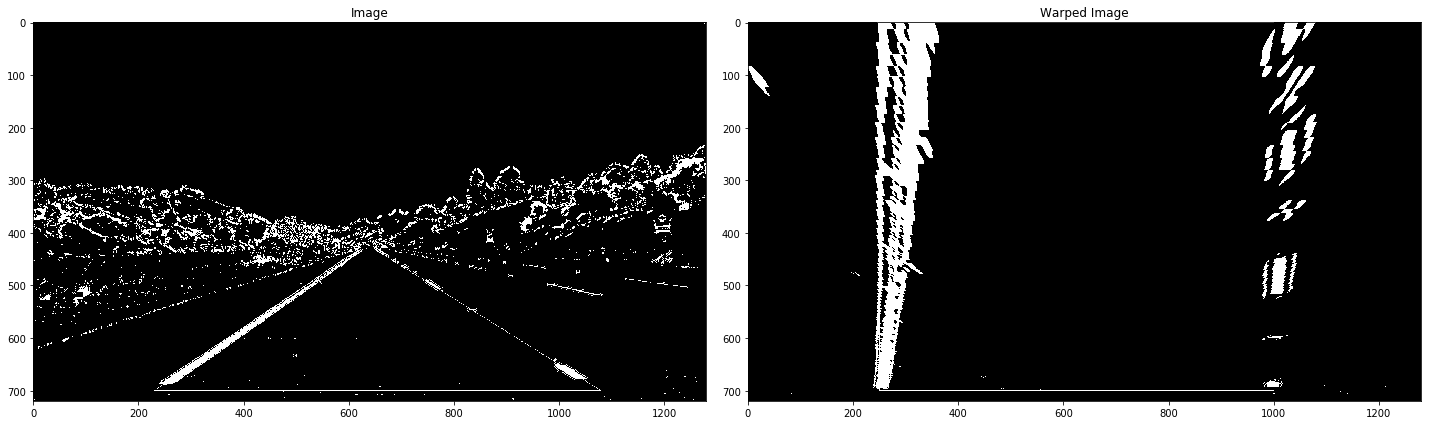

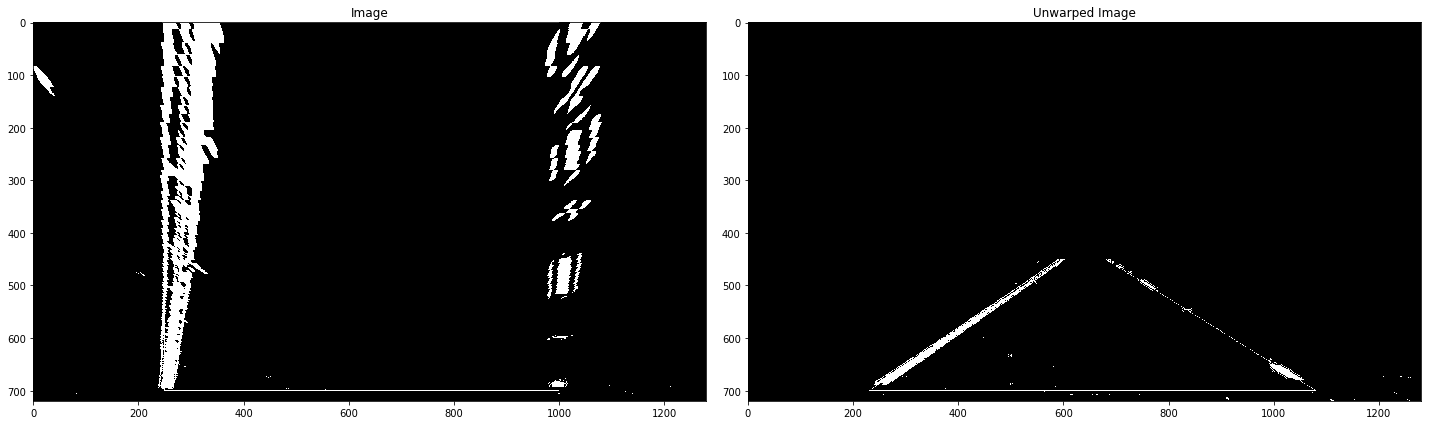

In [103]:
# Test (Thresholder ->) Transformer
image = mpimg.imread('test_images/straight_lines1.jpg')
undist_image = calibrator.Undistort(image)
thresholder = Thresholder()
thresholded_image = thresholder.apply_all(undist_image, show=False)
transformer = PerspectiveTransformer()
warped_image = transformer.Warp(thresholded_image, show=True)
unwarped_image = transformer.Unwarp(warped_image, show=True)

## Lane detection

In [ ]:
# Defines the function to locate the lanes using histogram
# and then fit polynomials for left and right lanes
def detect_lanes(warp_image):
    height = warp_image.shape[0]
    width = warp_image.shape[1]
    
    # Calculate histogrm of bottom half of image along columns
    histogram = np.sum(warp_image[np.int(height/2):,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(height/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warp_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 20
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = height - (window+1)*window_height
        win_y_high = height - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # return the co-effs
    return left_fit, right_fit

In [ ]:
# Find lane pixels around using polynomials fitted using last frame.
# margin defines the search region
def update_lanes(warp_image, left_fit, right_fit, margin=100):
    nonzero = warp_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit_new = np.polyfit(lefty, leftx, 2)
    right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new    

In [ ]:
# Defines a class to describe the characteristics of each line detection
class Line():
        # Reset
    def reset(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # Minimum curvature allowed for a valid lane
        self.min_allowed_curvature = 200

    # Constructor
    def __init__(self):
        self.reset()
        
    # Do sanity check
    def sanity_check(self):                 
        # Check if radius of curvature is reasonable
        if self.radius_of_curvature <= self.min_allowed_curvature:
            #print('FAIL- ROC '+str(self.radius_of_curvature)+'is less than minROC '+str(self.min_allowed_curvature))
            return False
        # Line seems OK
        return True

left_lane = Line()
right_lane = Line()

In [ ]:
def get_roc_in_meters(ploty, left_fitx, right_fitx, ym_per_pix=30/720, xm_per_pix=3.7/700):
    y_eval = np.max(ploty)  
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radius of curvature for left and right lanes
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    left_roc = np.int(left_curverad)
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    right_roc = np.int(right_curverad)
    return left_roc, right_roc

In [ ]:
def check_lane_sanity(height, left_fit, right_fit):
    ploty = np.linspace(0, height-1, height)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Check if curvatures are reasonable
    left_roc, right_roc = get_roc_in_meters(ploty, left_fitx, right_fitx)
       
    if (right_roc < 400):
        #print('The right curvature is too low: '+str(right_roc)+'m')
        return False
    
    if (left_roc < 400):
        #print('The left curvature is too low: '+str(left_roc)+'m')
        return False

    if (np.abs(right_roc - left_roc) > 200):
        #print('The radius of curvature are too different. right: '+str(right_roc)+'m, left: '+str(left_roc)+'m')
        return False

    
    # Check if lanes are parallel
    # Compute the difference between x values
    diff_fit_x = right_fitx - left_fitx
    # Compute the variance
    var = np.var(diff_fit_x)
    # For a perfectly parallel lines, var is 0
    if (var > 10):
        print('Lanes are not parallel. Variance: '+str(var))
        return False
    
    # Lanes are probably fine
    return True

In [ ]:
def process_image(dist_image, show=False):
    # Undistort the image
    image = calibrator.Undistort(dist_image)
    # Apply gradient and color thresholds   
    thresholder = Thresholder()
    com_bin = thresholder.apply_all(image, show=show)
    # Apply perspective transformation
    transformer = PerspectiveTransformer()
    warped_image = transformer.Warp(com_bin, show=show)

    height = warped_image.shape[0]
    width = warped_image.shape[1]
    
    if (left_lane.detected == False) or (right_lane.detected == False):
        # Eiether left or right lane is not available. Let's do a full search
        left_fit, right_fit = detect_lanes(warped_image)
    else:
        # Lanes are present, let's do search around lanes extrapolated using polynomial
        left_fit, right_fit = update_lanes(warped_image, left_lane.current_fit, right_lane.current_fit)
        if check_lane_sanity(height, left_fit, right_fit):
            # Lanes seems to be invalid, let's do full search
            left_fit, right_fit = detect_lanes(warped_image)        

    # Update class states
    left_lane.detected = True
    right_lane.detected = True
    left_lane.current_fit = left_fit
    right_lane.current_fit = right_fit    
   
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Calculate x points for left and right lane for y points
    ploty = np.linspace(0, height-1, height)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Calculate offset
    xm_per_pix=3.7/700
    left_lane.line_base_pos = (np.int(width/2) - left_fitx[height-1]) * xm_per_pix
    right_lane.line_base_pos = (left_fitx[height-1] - np.int(width/2)) * xm_per_pix
    offset = np.around((((right_fitx[height-1] - left_fitx[height-1]) - np.int(width/2)) * xm_per_pix), 2)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lanes to a warped blank image
    # Draw lane boundaries in RED
    cv2.polylines(color_warp, np.int_([pts_left]), 0, (255,0, 0),20)
    cv2.polylines(color_warp, np.int_([pts_right]), 0, (255,0, 0),20)
    # Fill lane in GREEN
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0), lineType=4)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = transformer.Unwarp(color_warp) 
    # Add some information to the image
    left_roc, right_roc = get_roc_in_meters(ploty, left_fitx, right_fitx)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(newwarp,'RoC: L:'+str(left_roc)+'m'+' R:'+str(right_roc)+'m',(10,100), font, 1,(255,255,0),3,cv2.LINE_AA)
    cv2.putText(newwarp,'Offset: '+str(offset)+'m',(10,200), font, 1,(255,255,0),3,cv2.LINE_AA)
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.5, 0)
    return result

In [ ]:
# Let's test with test images
# Test warping
#dist_image = mpimg.imread('debug_images1/frame0042.jpeg')
dist_image = mpimg.imread('challenge_video_frames/frame0001.jpeg')
out_image = process_image(dist_image)
plt.imshow(out_image)

In [ ]:
# Let's try with videos
left_lane.reset()
right_lane.reset()
clip1 = VideoFileClip("project_video.mp4")
#subclip = clip1.subclip(0, 20)
#clip1.write_images_sequence('challenge_video_frames/frame%04d.jpeg')
processed_clip = clip1.fl_image(process_image)
output_video = 'marked_project_video.mp4'
%time processed_clip.write_videofile(output_video, audio=False)

left_lane = Line()
right_lane = Line()

myclip = VideoFileClip("project_video.mp4")
for frame in myclip.iter_frames():
    # Undistort the image
    image = cv2.undistort(frame, mtx, dist, None, mtx)
    # Apply gradient and color thresholds
    com_bin = apply_thresholds(image, ksize=3)
    warped_image = warp(com_bin)

    left_fit, right_fit = polyfit_lanes(warped_image)

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    left_roc = np.int(left_curverad)
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    right_roc = np.int(right_curverad)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = transformer.Unwarp(color_warp)
    # Add some information to the image
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(newwarp,'RoC: L:'+str(left_roc)+' R:'+str(right_roc),(10,100), font, 1,(255,255,0),3,cv2.LINE_AA)
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.5, 0)
    plt.imshow(result)
    